In [ ]:
"""
AI Usage Statement (Craig Woolley)
Tools Used: Gemini
    - Usage: Code for handling infinite values and NaN, Model architecture, understanding compiling model, evaluating performance
    - Verification: Code are manually written
Prohibited Use Compliance: Confirmed

Process data through the following steps:
1. Data Preprocessing: Load and preprocess the dataset, including handling missing values and scaling features.
2. Model Training: Train a machine learning model using the preprocessed data.
3. Model Evaluation: Evaluate the model's performance using appropriate metrics.
4. Model Saving: Save the trained model for future use.

"""

'\nAI Usage Statement (Craig Woolley)\nTools Used: Gemini\n    - Usage: Code for handling infinite values and NaN, Model architecture, understanding compiling model, evaluating performance\n    - Verification: Code are manually written\nProhibited Use Compliance: Confirmed\n\n'

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from keras import layers, losses, datasets, models



In [6]:
DATA_DIR = "./processed_data"

train_df = pd.read_csv(f"{DATA_DIR}/X_train.csv")
val_df   = pd.read_csv(f"{DATA_DIR}/X_val.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/X_test.csv")
y_test   = pd.read_csv(f"{DATA_DIR}/y_test.csv").iloc[:, 0]

# collapse all non-benign labels to generic “Attack”
y_test_bin = (y_test != "Benign").astype(int).values   # 0 = Benign, 1 = Attack

train_benign = train_df[train_df["Label"] == "Benign"]
val_benign   = val_df  [val_df  ["Label"] == "Benign"]

X_train_raw = train_benign.drop(columns=["Label"]).values
X_val_raw   = val_benign.drop(columns=["Label"]).values
X_test_raw  = test_df.values

In [7]:
print("Handle infinite values")
X_train_raw[np.isinf(X_train_raw)] = np.nan
X_val_raw[np.isinf(X_val_raw)] = np.nan
X_test_raw[np.isinf(X_test_raw)] = np.nan

imp = SimpleImputer(strategy="median").fit(X_train_raw)
X_train_imp = imp.transform(X_train_raw)
X_val_imp   = imp.transform(X_val_raw)
X_test_imp  = imp.transform(X_test_raw)




Handle infinite values


In [8]:
# Use scaler to learn the min max values but only for the training data
scaler = MinMaxScaler().fit(X_train_imp)
X_train = X_train_imp
X_val   = X_val_imp
X_test  = X_test_imp
print(f"Train shape: {X_train.shape}   Val: {X_val.shape}   Test: {X_test.shape}")
scaler = MinMaxScaler()
scaler.fit(X_train)
# transform the rest of the datasets using the same MinMaxScaler
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# output the scaled ranges to confirm it's working properly
print(f"X_train_scaled range: {X_train_scaled.min()} to {X_train_scaled.max()}")
print(f"X_val_scaled range:   {X_val_scaled.min()} to {X_val_scaled.max()}")
print(f"X_test_scaled range:  {X_test_scaled.min()} to {X_test_scaled.max()}")

Train shape: (203560, 48)   Val: (8705, 48)   Test: (117774, 48)
X_train_scaled range: 0.0 to 1.0000000000000002
X_val_scaled range:   0.0 to 1.0
X_test_scaled range:  -8.658729390837911e-13 to 1.0806255220533834


In [9]:
# Cell to Define the models architecture

# Get the number of features from the scaled data (62)
input_dim = X_train_scaled.shape[1]

# Define the bottleneck size 
# this can be changed in hyperparameter tuning
# compress from 62 to 32 features
encoding_dim = 12
# print out both feature sizes to see 
print(f"Input dimension: {input_dim}")
print(f"Encoding dimension: {encoding_dim}")

# define the autoencoder 
autoencoder = keras.Sequential(
    [
        # define the input shape in for the first layer
        layers.Input(shape=(input_dim,)),
        # encoder we can add layers or change neuron counts in hyperparameter tuning
        layers.Dense(64, activation="relu"),
        layers.Dense(48, activation="relu"),
        layers.Dense(24, activation="relu"),
        layers.Dense(encoding_dim, activation="relu"),
        layers.Dense(24, activation="relu"),
        layers.Dense(48, activation="relu"),

        #decoder basically same as the encoder
        layers.Dense(64, activation="relu"),
        layers.Dense(input_dim, activation="sigmoid")
    ],
    # give the model a name to reference later
    name="autoencoder"
)

# show the architecture of the model 
print("\nModel Summary:")
autoencoder.summary()



Input dimension: 48
Encoding dimension: 12

Model Summary:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 48)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 48)             │         3,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,500 (60.55 KB)

 Trainable params: 15,500 (60.55 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compiling the model 

# choose an optimizer 
optimizer = 'adam'

# choose a loss funciton use mse here could also use binary_crossentropy
loss_function = 'mse'

print(f"Compiling model with optimizer='{optimizer}' and loss ='{loss_function}'")

#compile the autoencoder
autoencoder.compile(optimizer=optimizer, loss=loss_function)

print("Success!")


Compiling model with optimizer='adam' and loss ='mse'
Success!


In [ ]:
# training the model 

# define hyperparameters 
num_epochs = 50
batch_size = 32
# this object will store the loss values for each epoch which can be got using 
# history.history['loss'] and history.history['val_loss']
history = autoencoder.fit(
    X_train_scaled, 
    X_train_scaled, 
    epochs=num_epochs, 
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_val_scaled, X_val_scaled) 
)

print("Training of model complete!")

Epoch 1/50


KeyboardInterrupt: 

: 

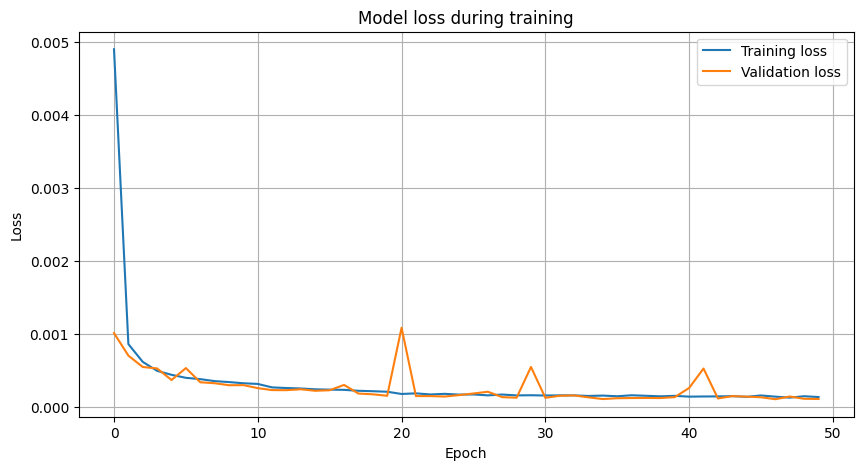

In [ ]:
# Plot the tarinng and validation loss

# get the history from the history object defined in the cell above
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(10,5))
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.title('Model loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


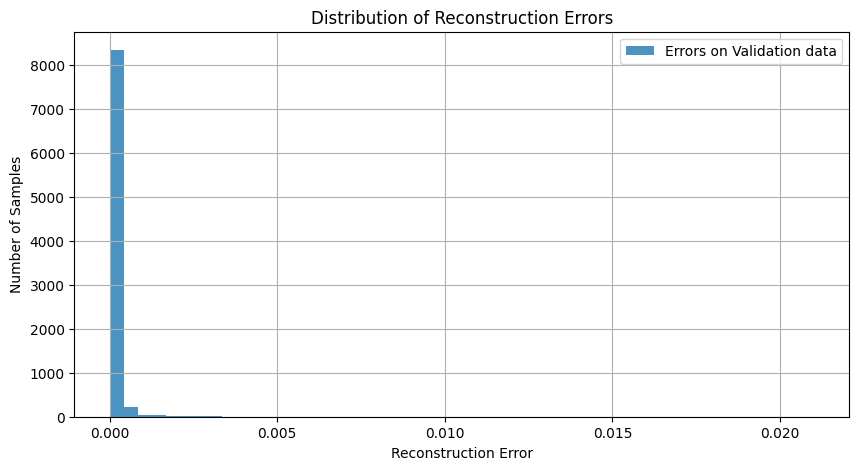

Chosen anomaly threshold (99th percentile of val errors): 0.001351


In [ ]:
# Anomaly threshold created using validation data

# reconstruct the validation data
reconstruct_val = autoencoder.predict(X_val_scaled)
# determine the reconstruction error for each val sample
val_errors = np.mean(np.power(X_val_scaled - reconstruct_val, 2), axis=1)

# plot the errors on validation data
plt.figure(figsize=(10,5))
plt.hist(val_errors, bins=50, alpha=0.8, label='Errors on Validation data')
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.grid(True)
plt.show()

# Determine the threshold with a percentile 
percentile = 99
threshold = np.percentile(val_errors, percentile)

print(f"Chosen anomaly threshold ({percentile}th percentile of val errors): {threshold:.6f}")


In [ ]:
# evaluate the performance of the model 

# reconstruct the test data set
reconstruct_test = autoencoder.predict(X_test_scaled)

# determine the reconstruction error for each test sample
test_errors = np.mean(np.power(X_test_scaled - reconstruct_test, 2), axis=1)

# predict based on the threshold
y_pred = (test_errors > threshold).astype(int)

# prepare the labels for the benign samples 
y_test_benign = np.where(y_test == 'Benign', 0, 1)

# calculate and display metrics
print(" Evaluation Metrics ")
print(f"Anomaly threshold: {threshold:.6f}")

accuracy = accuracy_score(y_test_benign, y_pred)
precision = precision_score(y_test_benign, y_pred)
recall = recall_score(y_test_benign, y_pred)
f1 = f1_score(y_test_benign, y_pred)

# output the metrics 
print(f"Accuracy: {accuracy:.4f}")
print(f"Precission: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# show the classification report
print("Classification Report: ")
print(classification_report(y_test_benign, y_pred, target_names=['Benign', 'Bot']))

print("Confusion Matrix: ")
confusion_matrix = confusion_matrix(y_test_benign, y_pred)
print(confusion_matrix)




3681/3681 ━━━━━━━━━━━━━━━━━━━━ 2s 457us/step
 Evaluation Metrics 
Anomaly threshold: 0.001351
Accuracy: 0.6712
Precission: 0.6156
Recall: 0.0350
F1-Score: 0.0663
Classification Report: 
              precision    recall  f1-score   support

      Benign       0.67      0.99      0.80     78535
         Bot       0.62      0.04      0.07     39239

    accuracy                           0.67    117774
   macro avg       0.64      0.51      0.43    117774
weighted avg       0.65      0.67      0.56    117774

Confusion Matrix: 
[[77677   858]
 [37865  1374]]
